Global Warming is one of the greatest long-term threats to hedgehogs. Everyone in the multi-universe knows that hedgehogs are the best. Therefore, it is our direct duty to start research on the phenomenon of Global Warming in order to be able to cope with it. 

For the sake of all the Goodness in the Universe we shall implement the Hedgehongs Saving Initiative. Hereupon, in this project we shall take preliminary steps to investigate the anomalies in the planetary temperature that took place from the beginning of the 21st century.

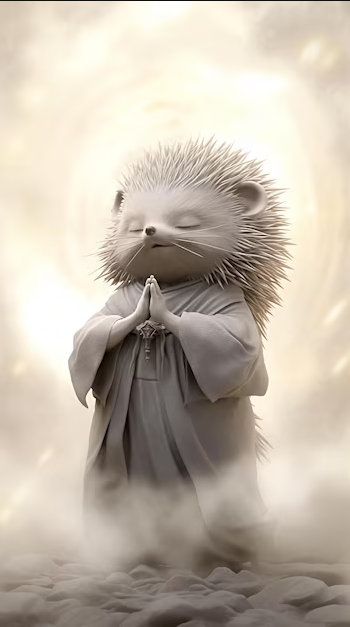

The data used in the project has been retrieved from:
https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/global/time-series/globe/tavg/land_ocean/1/0/2000-2024

                        ======================== « STEP_1: SET UP » =======================

In [1]:
# installing pmdarima
!pip install pmdarima

# importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import numpy as np

# loading the dataset
url = "https://raw.githubusercontent.com/DSE-24-25/project-OmarovTimur/main/data.csv"
data = pd.read_csv(url, comment='#')

# converting the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%Y%m')
data.set_index('Date', inplace=True)

# focusing on the data starting from the beginning of the 21st century
data = data[data.index >= pd.to_datetime('2000-01-01')]

# displaying the first few rows of the dataset
print(data.head())

            Anomaly
Date               
2000-01-01     0.32
2000-02-01     0.54
2000-03-01     0.53
2000-04-01     0.59
2000-05-01     0.37


                     =================== « STEP_2: VISUALISATION OF DATASET » =====================

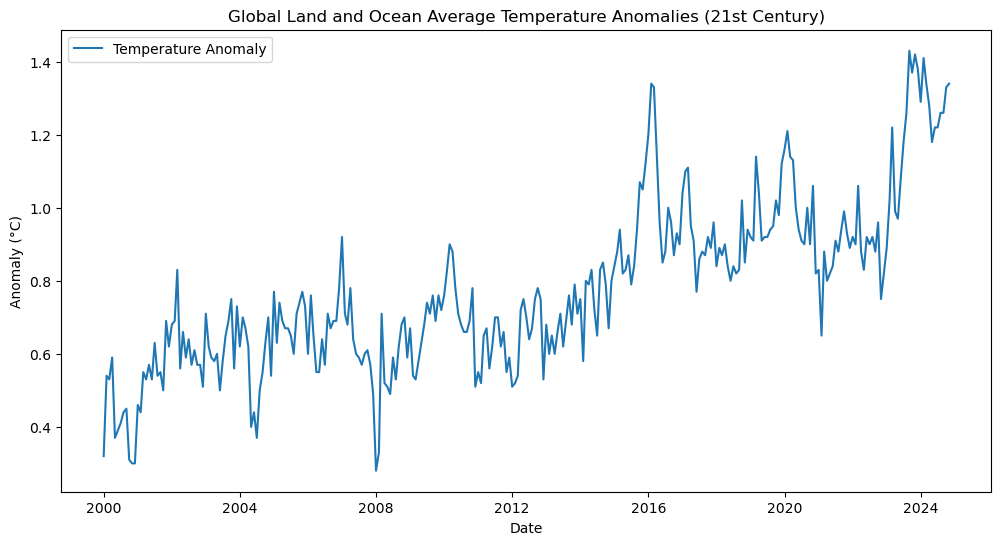

In [2]:
# plotting the time series
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Anomaly'], label='Temperature Anomaly')
plt.title('Global Land and Ocean Average Temperature Anomalies (21st Century)')
plt.xlabel('Date')
plt.ylabel('Anomaly (°C)')
plt.legend()
plt.show()

                       ======================== « STEP_3: TRAIN & TEST » =========================

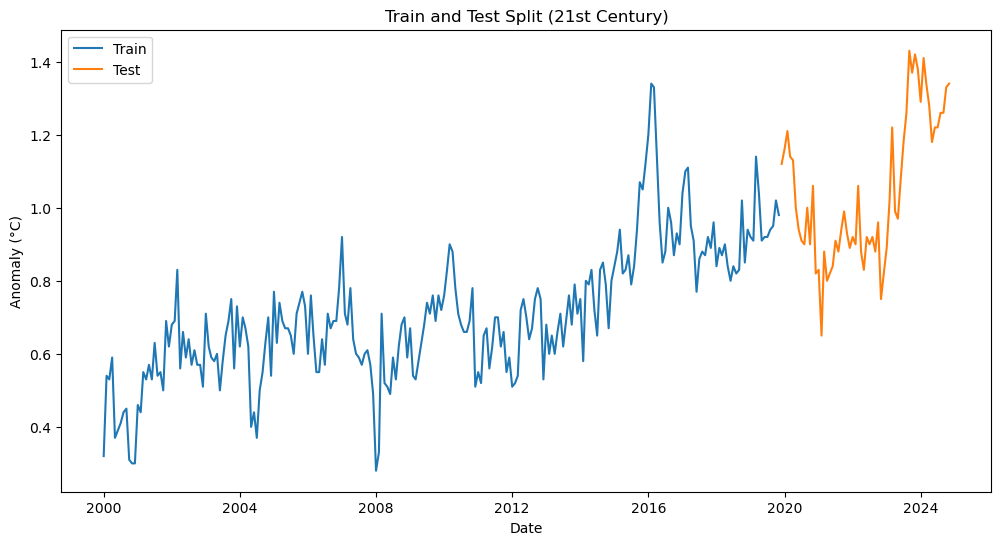

In [3]:
# splitting the time series: 80% - Train part, 20% - Test part
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# plotting the Train and Test sets
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Anomaly'], label='Train')
plt.plot(test.index, test['Anomaly'], label='Test')
plt.title('Train and Test Split (21st Century)')
plt.xlabel('Date')
plt.ylabel('Anomaly (°C)')
plt.legend()
plt.show()

                        ====================== « STEP_4: DECOMPOSITION» =======================

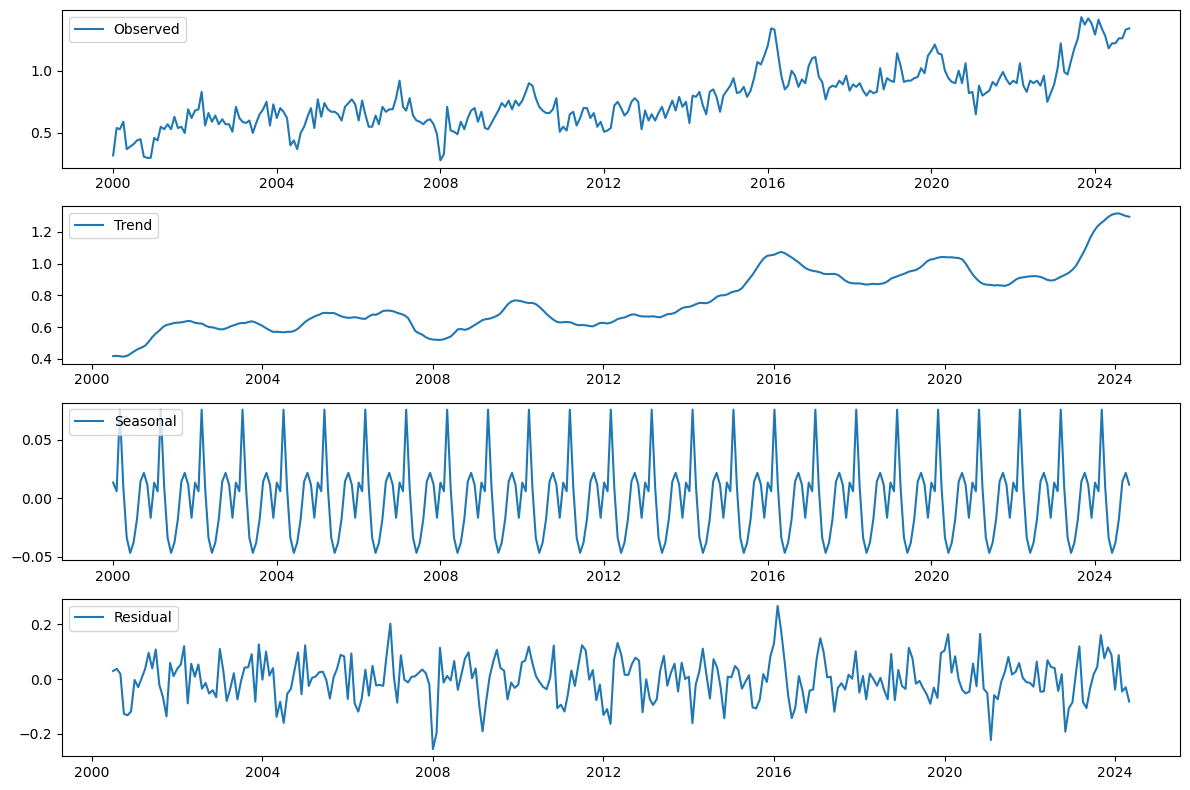

In [4]:
# decomposing the time series into Trend, Seasonal and Residual components
result = seasonal_decompose(data['Anomaly'], model='additive', period=12)

# plotting the decomposed components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(result.observed, label='Observed')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(result.resid, label='Residual')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

                      ====================== « STEP_5: RANDOM FOREST FORECAST » ====================

Fitting 3 folds for each of 16 candidates, totalling 48 fits


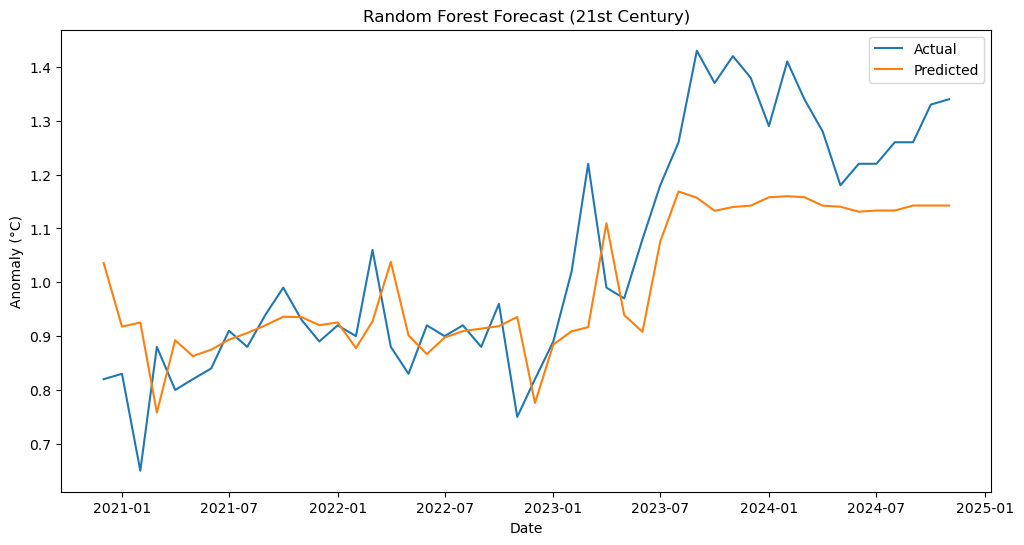

Random Forest Mean Squared Error: 0.019578768617984004


In [5]:
from sklearn.model_selection import GridSearchCV

# fixing the SettingWithCopyWarning by using .assign() and .copy()
# creating features 
train = train.copy().assign(Month=train.index.month)
test = test.copy().assign(Month=test.index.month)

# creating lag features
for lag in range(1, 13):
    train[f'Lag_{lag}'] = train['Anomaly'].shift(lag)
    test[f'Lag_{lag}'] = test['Anomaly'].shift(lag)

# dropping rows with NaN values (due to lagging)
train = train.dropna()
test = test.dropna()

# defining the features and target variable
X_train = train.drop(columns=['Anomaly'])
y_train = train['Anomaly']
X_test = test.drop(columns=['Anomaly'])
y_test = test['Anomaly']

# simplified parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# initializing GridSearchCV with RandomForestRegressor
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# getting the best parameters and train the final model
best_params = grid_search.best_params_
rf_model_tuned = RandomForestRegressor(**best_params)
rf_model_tuned.fit(X_train, y_train)

# making predictions
rf_predictions_tuned = rf_model_tuned.predict(X_test)

# plotting the predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Actual')
plt.plot(test.index, rf_predictions_tuned, label='Predicted')
plt.title('Random Forest Forecast (21st Century)')
plt.xlabel('Date')
plt.ylabel('Anomaly (°C)')
plt.legend()
plt.show()

# calculating MSE of the predictions
rf_mse = mean_squared_error(y_test, rf_predictions_tuned)
print(f'Random Forest Mean Squared Error: {rf_mse}')

Overall, the RF prediction looks good, but with slight deviation in the latter period. It might be because the Random Forest technique may not handle temporal dependencies, like sudden climate events.The model also may have learned some noise from the training data, reducing its ability to generalize.

                      ==================== « STEP 6: ETS MODEL FORECAST » ========================

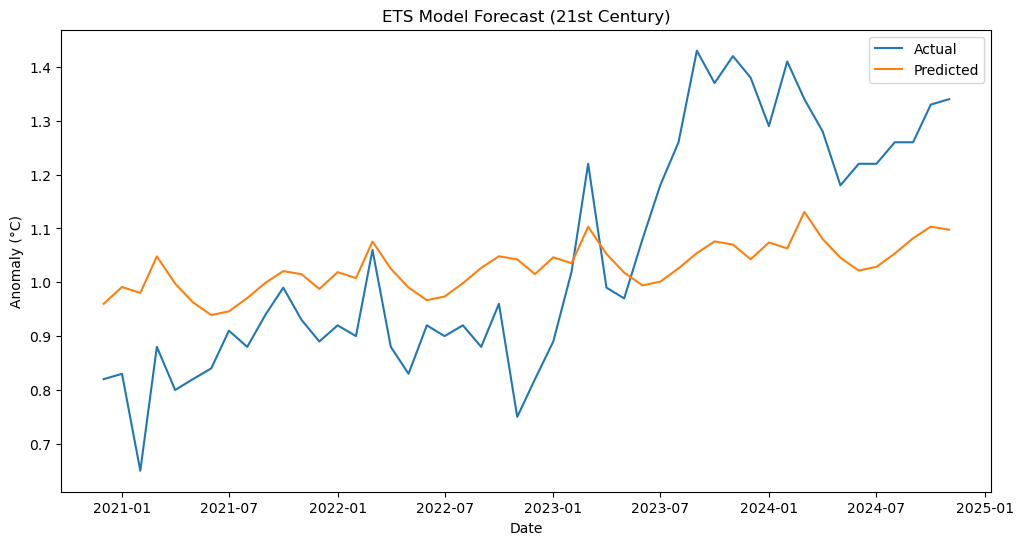

ETS Model Mean Squared Error: 0.03438011484906623


In [6]:
# ensuring the Date index has a specified frequency
train = train.asfreq('MS')
test = test.asfreq('MS')

# training the Exponential Smoothing model on the training data
ets_model_tuned = ExponentialSmoothing(train['Anomaly'], trend='add', seasonal='add', seasonal_periods=12).fit()

# making predictions for the test period
ets_predictions_tuned = ets_model_tuned.forecast(len(test))

# plotting the predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Actual')
plt.plot(test.index, ets_predictions_tuned, label='Predicted')
plt.title('ETS Model Forecast (21st Century)')
plt.xlabel('Date')
plt.ylabel('Anomaly (°C)')
plt.legend()
plt.show()

# calculating the MSE of the predictions
ets_mse = mean_squared_error(y_test, ets_predictions_tuned)
print(f'ETS Model Mean Squared Error: {ets_mse}')

The ETS model diverges from the real data as we get closer to the dataset's boundaries and aligns better closer to the middle. One of the possible reasons is that we overfitted the model to the middle portion of the data, leading to reduction of generalization at the edges.

                       ======================== « STEP 7: ARIMA MODEL FORECAST » ======================

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-443.165, Time=14.51 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-411.165, Time=0.67 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-429.069, Time=1.76 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-433.398, Time=2.84 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-413.036, Time=0.34 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-444.776, Time=10.71 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-447.161, Time=4.68 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-444.906, Time=10.64 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=inf, Time=4.58 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=3.81 sec
 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=-445.100, Time=4.89 sec
 ARIMA(2,1,3)(0,0,0)[12] intercept   : AIC=-444.893, Time=5.88 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-443.116, Time=3.58 sec
 ARIMA(1,1,3)(0,0,0)[12] intercept   : AIC=-443.621, Time=6.69 sec
 ARIMA(3,1,1)(0,0,0)[12] i

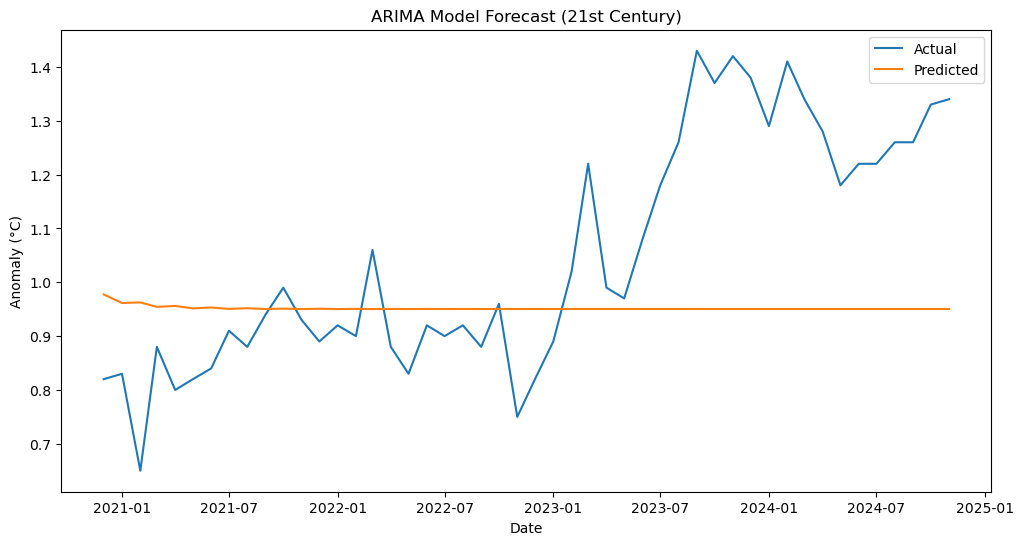

ARIMA Model Mean Squared Error: 0.055133020195152316


In [7]:
# automatically finding the best ARIMA parameters
auto_arima_model = auto_arima(train['Anomaly'], seasonal=True, m=12, trace=True)
arima_model_tuned = ARIMA(train['Anomaly'], order=auto_arima_model.order, seasonal_order=auto_arima_model.seasonal_order)
arima_model_fit_tuned = arima_model_tuned.fit()

# making predictions for the test period
arima_predictions_tuned = arima_model_fit_tuned.forecast(steps=len(test))

# plotting the predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Actual')
plt.plot(test.index, arima_predictions_tuned, label='Predicted')
plt.title('ARIMA Model Forecast (21st Century)')
plt.xlabel('Date')
plt.ylabel('Anomaly (°C)')
plt.legend()
plt.show()

# calculating the MSE of the predictions
arima_mse = mean_squared_error(y_test, arima_predictions_tuned)
print(f'ARIMA Model Mean Squared Error: {arima_mse}')

ARIMA reminds a flattened ETS we've obtained above. It might be due to not the best choice of hyperparameters (such as p, d, q), which can lead to overfitting at the middle and poorer performace in capturing trends and seasonality.

                        =============== « STEP 8: COMPARISON OF 3 APPROACHES » ==============

Random Forest Mean Squared Error: 0.019578768617984004
ETS Model Mean Squared Error: 0.03438011484906623
ARIMA Model Mean Squared Error: 0.055133020195152316


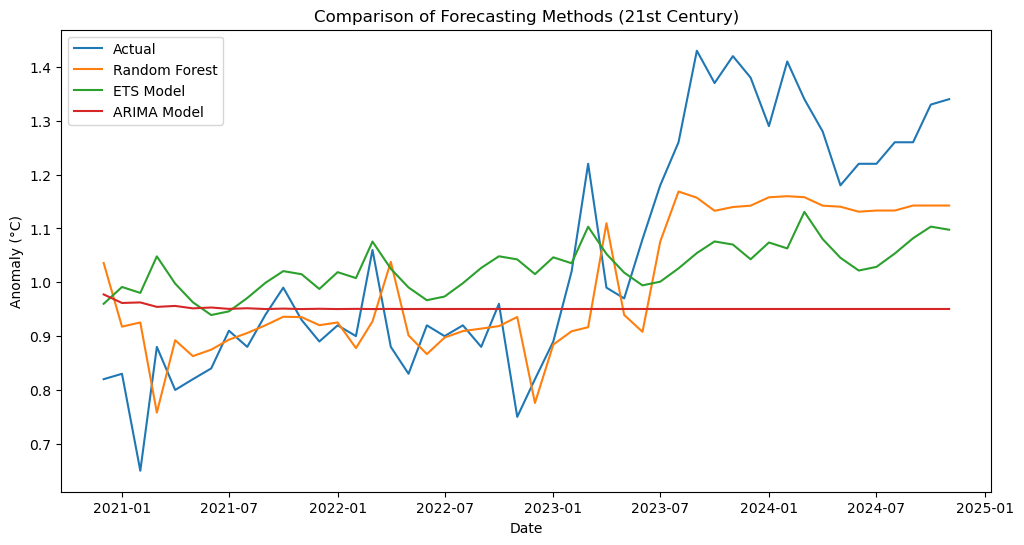

In [8]:
# printing the MSE of the three models
print(f'Random Forest Mean Squared Error: {rf_mse}')
print(f'ETS Model Mean Squared Error: {ets_mse}')
print(f'ARIMA Model Mean Squared Error: {arima_mse}')

# plotting the actual values and the predictions of the three models
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Actual')
plt.plot(test.index, rf_predictions_tuned, label='Random Forest')
plt.plot(test.index, ets_predictions_tuned, label='ETS Model')
plt.plot(test.index, arima_predictions_tuned, label='ARIMA Model')
plt.title('Comparison of Forecasting Methods (21st Century)')
plt.xlabel('Date')
plt.ylabel('Anomaly (°C)')
plt.legend()
plt.show()

Random Forest MSE < ETS MSE < ARIMA MSE => Random Forest is the best approach here.